In [1]:
# --- load libraries ---
from semanticgis.abstract import Pipeline, DataModel, SpatialNature, MeasurementScale, DataFormat
from semanticgis.compilers import mermaid, qgis_recipy, validate
from IPython.display import display, Markdown, HTML, Image

# --- Define Pipeline ---
p = Pipeline(name="Pipeline Demo")


## Notebook Overview
This notebook demonstrates how to import `semanticgis.abstract.Pipeline`, register semantic inputs, and compile the resulting DAG into Mermaid and QGIS documentation. Always run Cell 1 first to ensure the library is imported before executing the remaining steps.

## 1.  Declare input Data

In [3]:
p.io.declare_input(
    source="https://raw.githubusercontent.com/Esbern/gis_demo_data/main/europa.geojson",
    output_name="europa_countries",
    label="Europa countries dataset 2",
    spatial_nature=SpatialNature.DISCRETE,  # Defines it as a Vector/Object model
    data_model=DataModel.VECTOR,
    data_format=DataFormat.GEOJSON,
    description="European sovereign boundaries",
    attributes={
        "SOVEREIGNT": {
            "scale": MeasurementScale.NOMINAL,
            "description": "Full name of the sovereign state",
        },
        "POP_EST": {
            "scale": MeasurementScale.RATIO,
            "description": "Estimated population count",
        },
    },
)


## 2. Declare the processing steps

In [3]:
# Isolate the Kingdom of Denmark without storing a Python variable
p.extraction.filter_by_sql(
    dataset="europa_countries",
    where_clause="SOVEREIGNT = 'Denmark'",
    output_name="denmark_subset",
    label="Kingdom of Denmark",
)

# Buffer to find the 12 NM maritime boundary
p.proximity.buffer(
    dataset="denmark_subset",
    distance=0.22,  # approximately 12 nautical miles in degrees
    units="degrees",
    output_name="danish_territorial_sea",
    label="12 NM territorial buffer",
)

# Buffer to find the 59 NM maritime boundary
p.proximity.buffer(
    dataset="denmark_subset",
    distance=0.59,  # approximately 59 nautical miles in degrees
    units="degrees",
    output_name="danish_interest_zone",
    label="59 NM interest zone",
)


## 3. Visualize and Validate the Plan --

In [4]:
display(Markdown(mermaid.compile(p)))

```mermaid
flowchart TD

    %% -- Nodes --
    node_1_data((<b>europa_countries</b><br/>Europa countries dataset 2<br/><small>vector / mixed / discrete</small>))
    node_2_data((<b>denmark_subset</b><br/>Kingdom of Denmark<br/><small>vector / mixed / discrete</small>))
    node_3_data((<b>danish_territorial_sea</b><br/>12 NM territorial buffer<br/><small>vector / mixed / discrete</small>))
    node_4_data((<b>danish_interest_zone</b><br/>59 NM interest zone<br/><small>vector / mixed / discrete</small>))
    node_2_proc[Kingdom of Denmark<br/><small>extraction.filter_by_sql</small>]
    node_3_proc[12 NM territorial buffer<br/><small>proximity.buffer</small>]
    node_4_proc[59 NM interest zone<br/><small>proximity.buffer</small>]

    %% -- Connections --
    node_1_data --> node_2_proc
    node_2_data --> node_3_proc
    node_2_data --> node_4_proc
    node_2_proc --> node_2_data
    node_3_proc --> node_3_data
    node_4_proc --> node_4_data
```

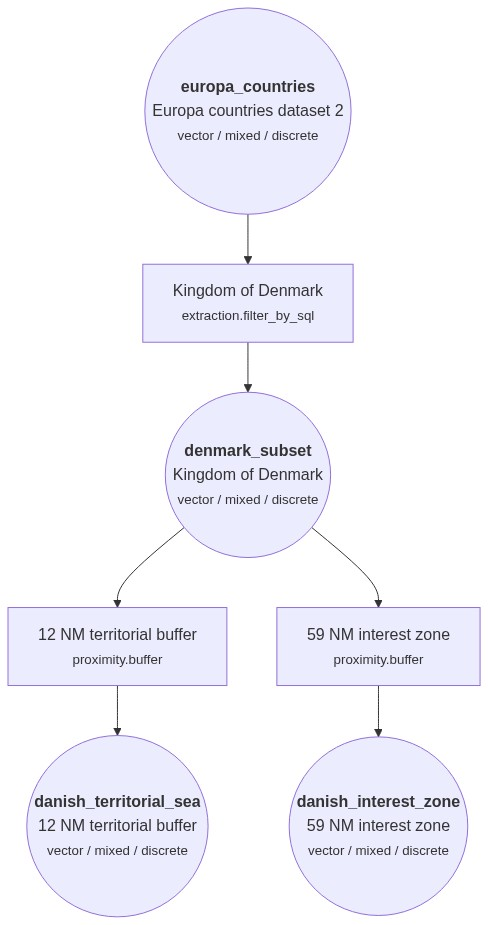

In [5]:
# Render via mermaid.ink (graph) and keep the Markdown block for docs export.
try:
    graph_png = mermaid.compile(p, type="graph", dpi=175, return_bytes=True)
except RuntimeError as exc:
    display(Markdown(f"Mermaid render failed: {exc}"))
else:
    display(Image(data=graph_png))

## 4. Display a QGIS recipy

In [6]:
display(Markdown(qgis_recipy.compile(p)))

# QGIS Recipe: Pipeline Demo

---

### Step 1: Europa countries dataset 2

**Action**: Load a vector layer and register it as `europa_countries`.

* **Details**: Use `Layer > Add Layer > Add Vector Layer...` and browse to `https://raw.githubusercontent.com/Esbern/gis_demo_data/main/europa.geojson`. Format hint: `geojson`.

---

### Step 2: Kingdom of Denmark

**Action**: Run a SQL query using the DB Manager or Virtual Layer feature.

* **Details**:
    * *Source layer*: `Europa countries dataset 2`
    * *WHERE clause*: `SOVEREIGNT = 'Denmark'`

---

### Step 3: 12 NM territorial buffer

**Action**: Run the Processing Toolbox → Buffer tool.

* **Settings**:
    * *Input*: `Kingdom of Denmark`
    * *Distance*: `0.22 degrees`
    * Ensure the layer is in an appropriate projected CRS before buffering.

---

### Step 4: 59 NM interest zone

**Action**: Run the Processing Toolbox → Buffer tool.

* **Settings**:
    * *Input*: `Kingdom of Denmark`
    * *Distance*: `0.59 degrees`
    * Ensure the layer is in an appropriate projected CRS before buffering.

## 5. Validate the pipeline semantics

In [7]:
validate.compile(p)

✅ SUCCESS: All workflow checks passed!


## 6. Execution placeholder
The Python executor is paused during the functional-complex refactor. Once it returns, this section will demonstrate how to materialise the territorial sea features and render them in Folium.